In [1]:
from functions.functions import *
import warnings
import soundfile
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # This is to avoid the memory fragmentation

# Retina display
%config InlineBackend.figure_format = 'retina'

CUDA is available. Using GPU.


In [2]:
!pip install torchvision

In [3]:
device

device(type='cuda')

In [4]:
img_path = "Lenna.png"
if not (os.path.exists(img_path)):
  !wget "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" -O "Lenna.png"
original_img = load_and_preprocess_image(img_path, top = 0 , left = 0 , crop_size=512)


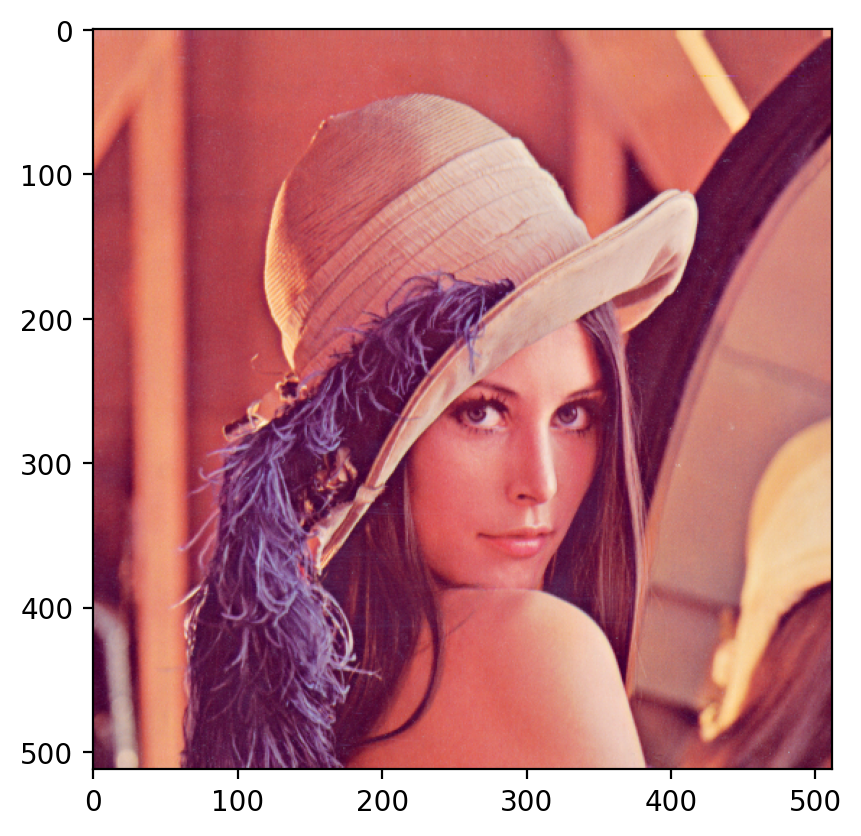

In [5]:
plt.imshow(rearrange(original_img, 'c h w -> h w c').numpy())

In [6]:
X, Y = (create_coordinate_map(original_img))
scaled_X, scaler = scale_coordinates(X)

In [7]:
X_rff = create_rff_features(scaled_X, 20000, 0.008).to(device)

In [8]:
net = LinearModel(X_rff.shape[1], 3).to(device)
train(net, 0.005, X_rff.to(device), Y.to(device), 1000)

Epoch 0 loss: 0.300078
Epoch 100 loss: 0.036564
Epoch 200 loss: 0.008713
Epoch 300 loss: 0.004608
Epoch 400 loss: 0.003104
Epoch 500 loss: 0.002313
Epoch 600 loss: 0.001870
Epoch 700 loss: 0.001616
Epoch 800 loss: 0.001471
Epoch 900 loss: 0.001387


0.0013387514045462012

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


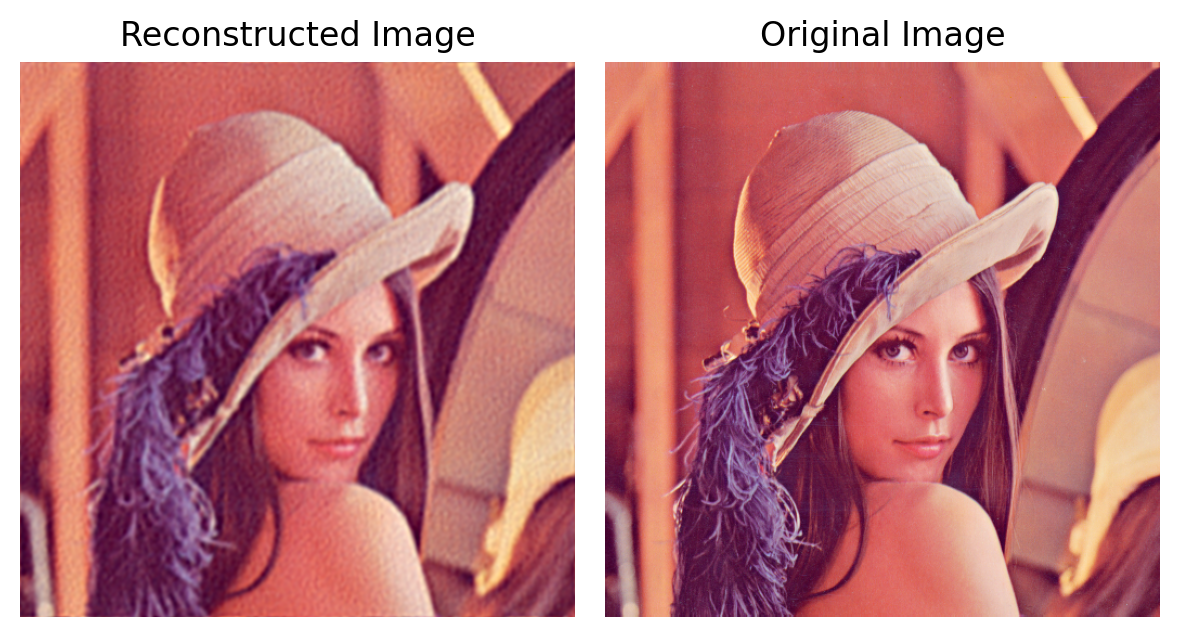

In [9]:
_ = plot_reconstructed_and_original_image(original_img, net, X_rff, title="")

In [22]:
metrics = calculate_metrics(Y.to(device), predict_image(net, X_rff))
print(f"RMSE: {metrics[0]:.6f}, PSNR: {metrics[1]:.6f}")
del(X_rff)

RMSE: 0.036584, PSNR: 28.734205


In [23]:
from IPython.display import Audio
import torchaudio
org_sound_path = 'ES335-MLAssignment2/trimmed-pokemon-22k.wav'
Audio(org_sound_path)

In [24]:
audio, sr = torchaudio.load("./"+org_sound_path)
print(f"Sampling frequency: {sr} Hz")
print(audio.shape)
audio = audio[0]

Sampling frequency: 22050 Hz
torch.Size([2, 394584])


In [25]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

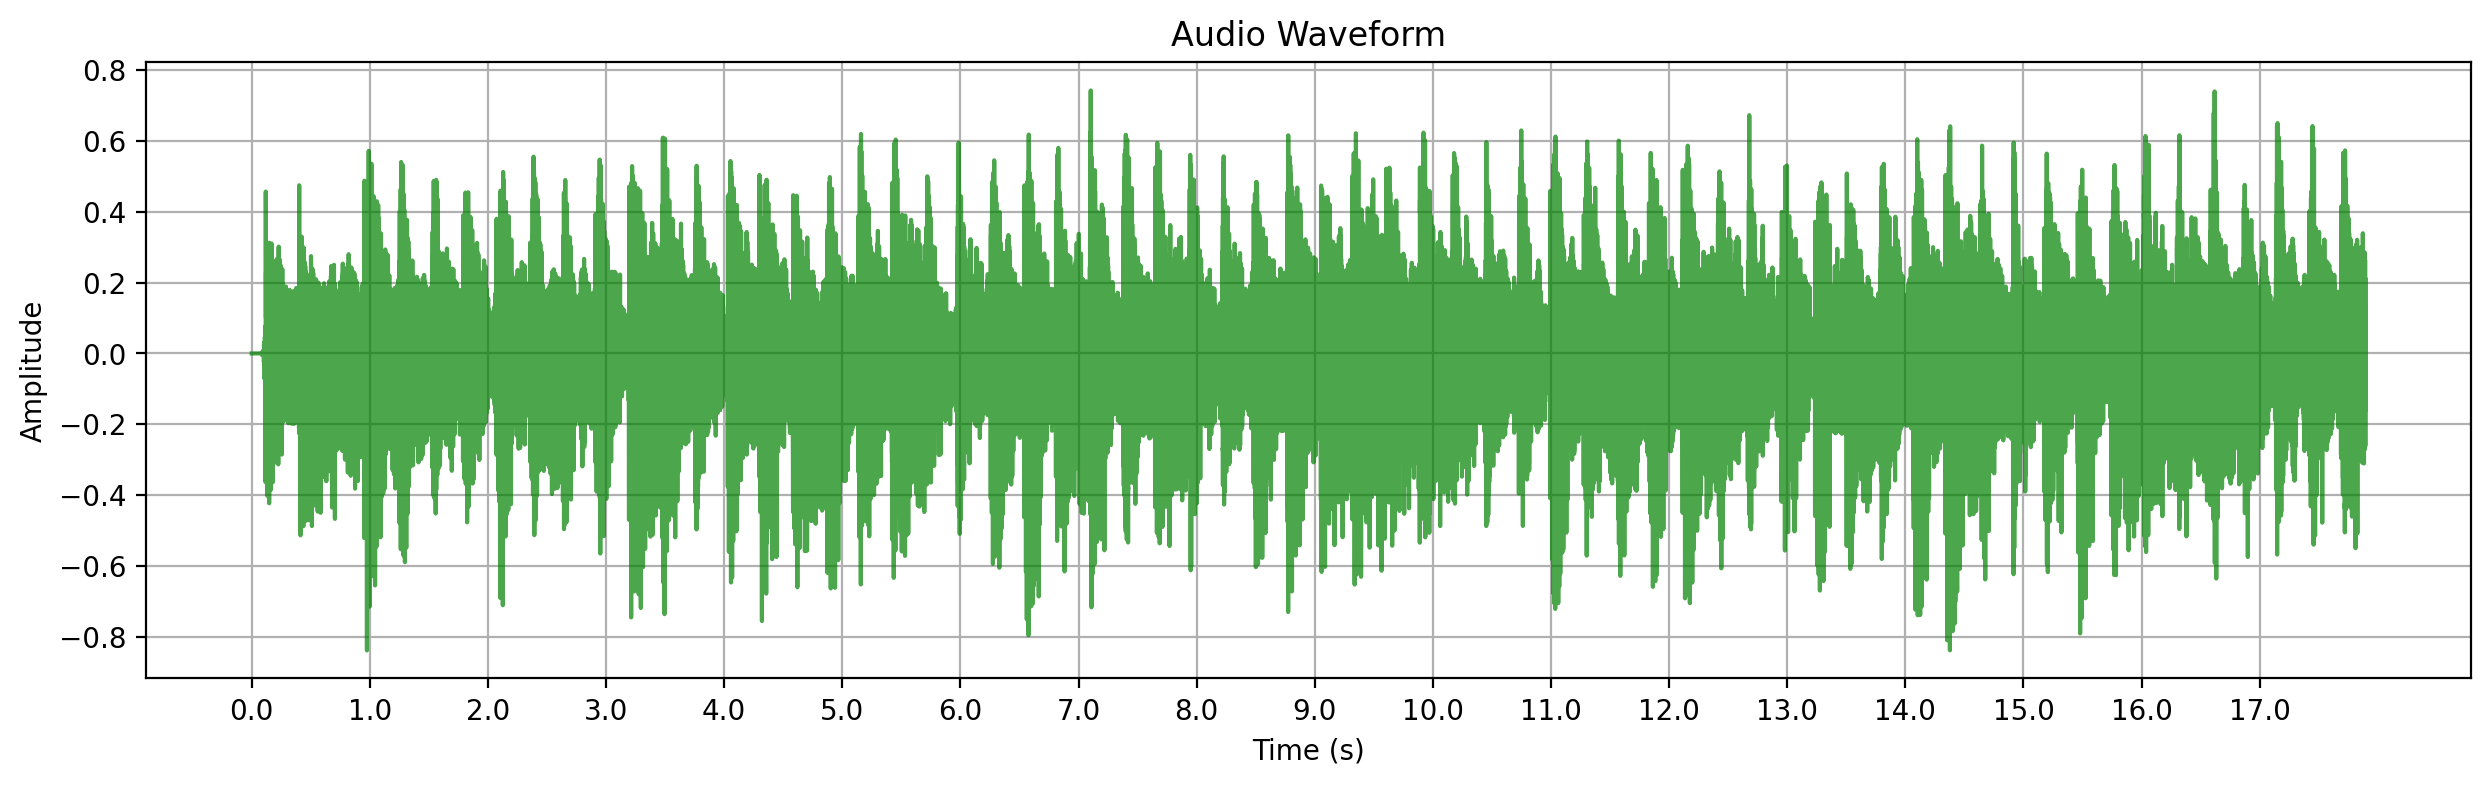

In [26]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [27]:
audio_tr = audio[:5*sr]
audio_infer = audio[:10*sr]
X = torch.arange(0, len(audio_tr)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
X_infer = torch.arange(0, len(audio_infer)).unsqueeze(1).float()
X_infer = X_infer/X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([110250, 1])
tensor([[-100.0000],
        [ -99.9982],
        [ -99.9964],
        ...,
        [  99.9964],
        [  99.9982],
        [ 100.0000]])


In [28]:
Audio(audio_tr, rate = sr)

In [50]:
del(X_rff)

In [51]:
num_features = 15000
sigma = 0.008
X_rff = create_rff_features(X, num_features, sigma).to(device)
X_rff_infer = create_rff_features(X_infer, num_features, sigma).to(device)
X_rff.shape

torch.Size([110250, 15000])

In [53]:
net = LinearModel(X_rff.shape[1], 1)
net.to(device)
X_rff = X_rff.to(device)
audio_tr = audio_tr.view(-1, 1).to(device)
train(net, 0.001, X_rff, audio_tr, 2000)

Epoch 0 loss: 0.021287


Epoch 100 loss: 0.012593
Epoch 200 loss: 0.009343
Epoch 300 loss: 0.007569
Epoch 400 loss: 0.006443
Epoch 500 loss: 0.005661
Epoch 600 loss: 0.005086
Epoch 700 loss: 0.004644
Epoch 800 loss: 0.004295
Epoch 900 loss: 0.004012
Epoch 1000 loss: 0.003779
Epoch 1100 loss: 0.003584
Epoch 1200 loss: 0.003420
Epoch 1300 loss: 0.003279
Epoch 1400 loss: 0.003158
Epoch 1500 loss: 0.003053
Epoch 1600 loss: 0.002960
Epoch 1700 loss: 0.002879
Epoch 1800 loss: 0.002806
Epoch 1900 loss: 0.002742


0.002683833474293351

In [54]:
net.eval()
with torch.no_grad():
  pred_audio = net(X_rff).cpu().numpy().flatten()
  del(X_rff)
  infer_audio = net(X_rff_infer).cpu().numpy().flatten()
  del(X_rff_infer)

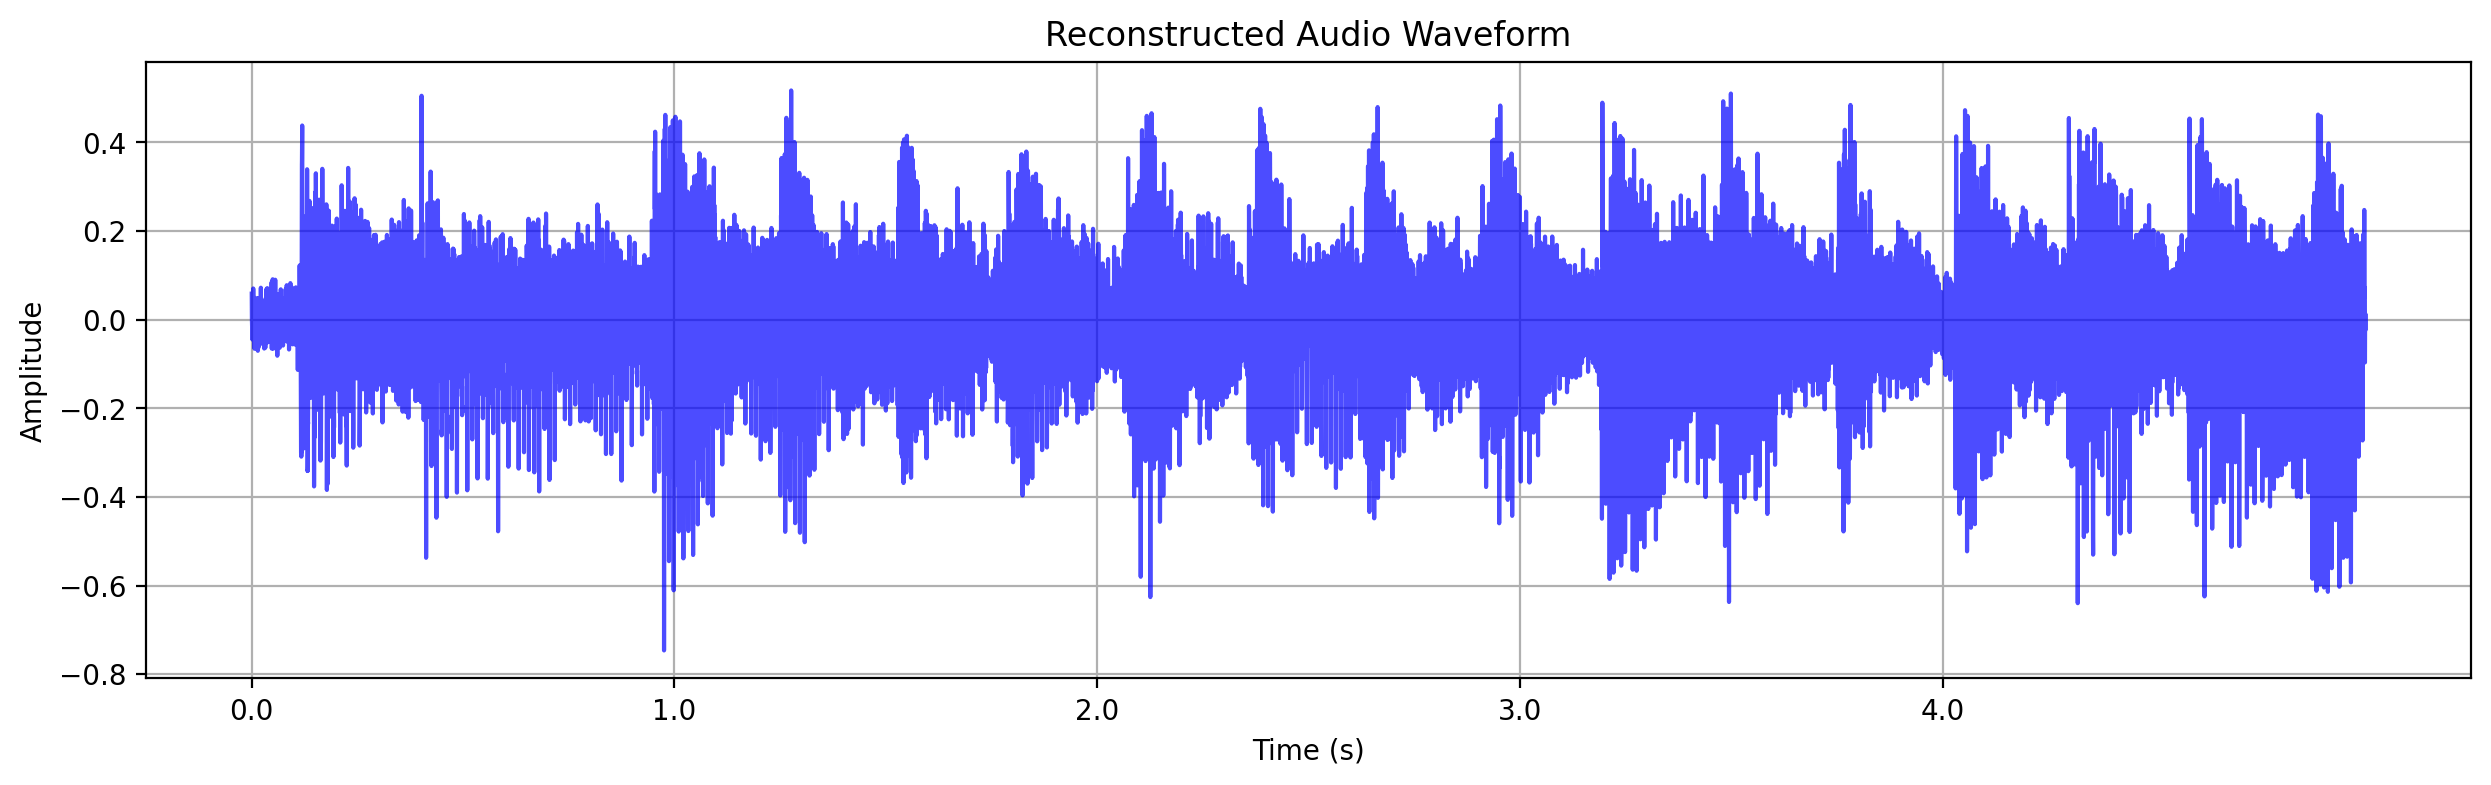

In [55]:
display(Audio(pred_audio, rate = sr))
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')
import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

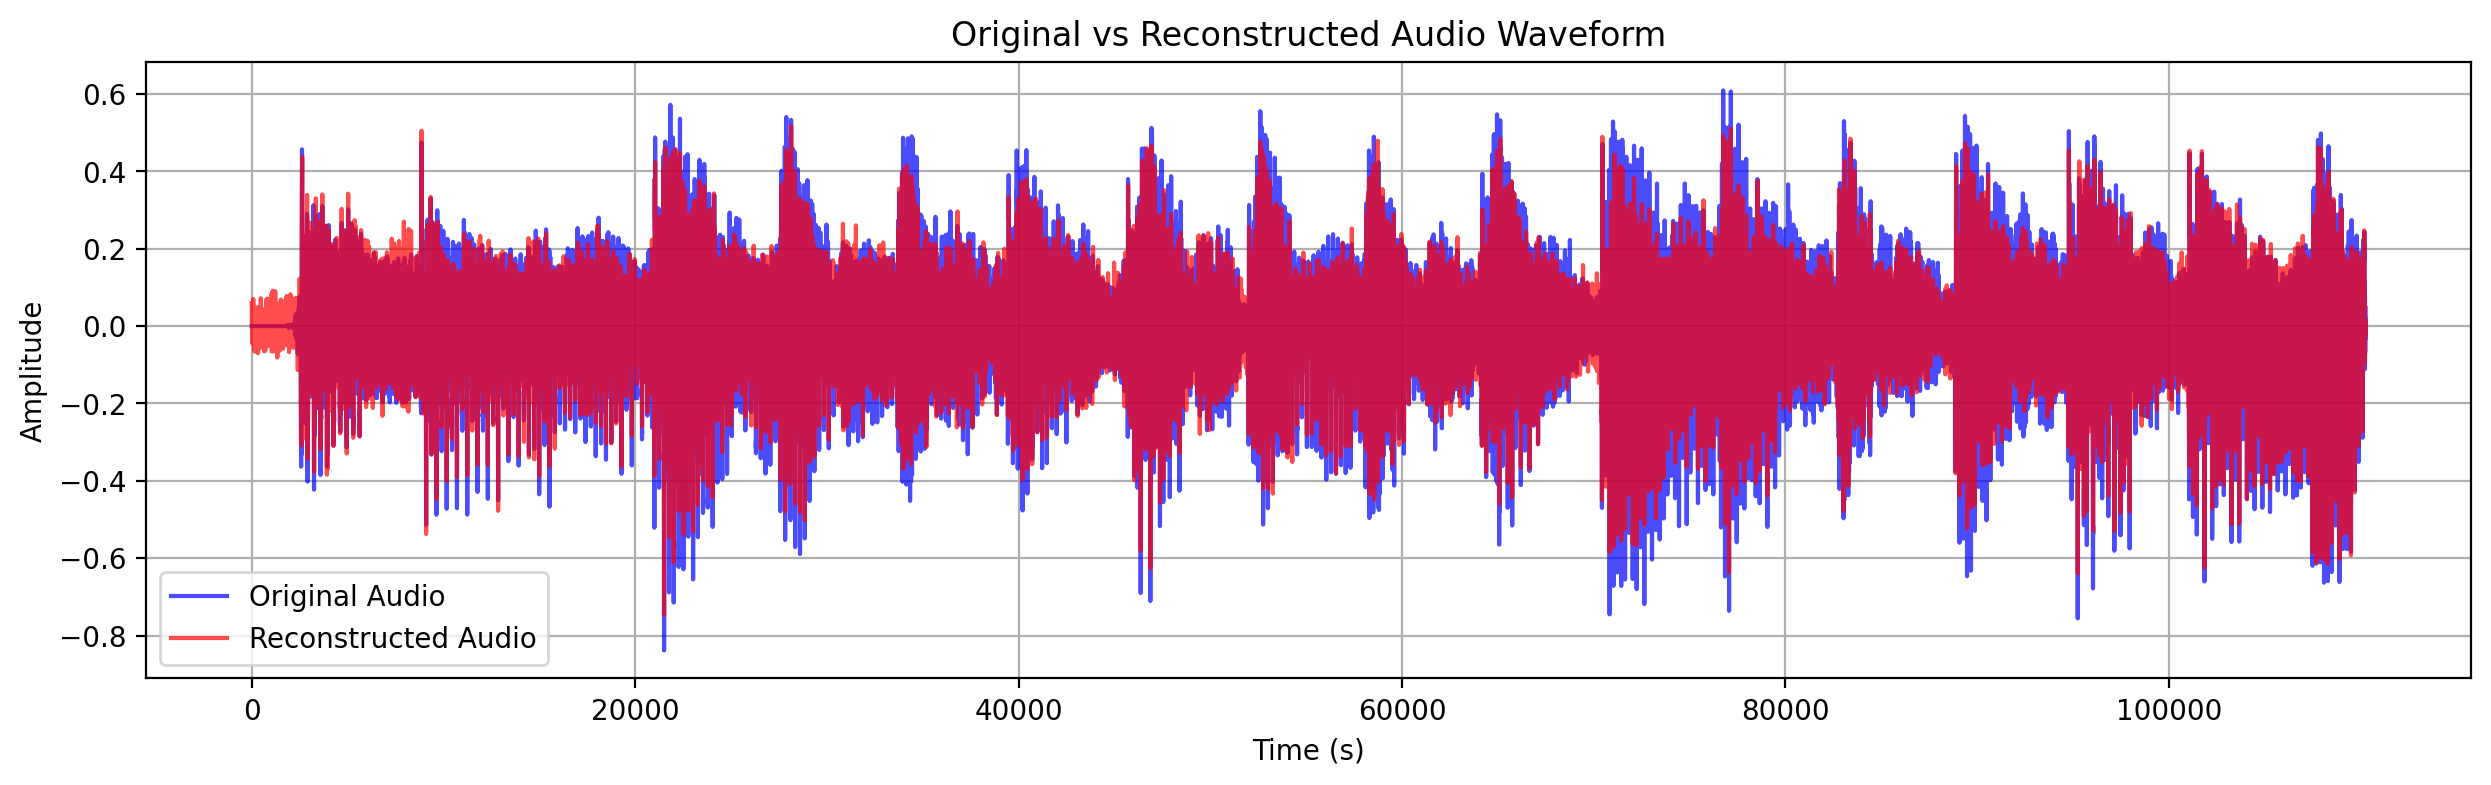

In [56]:
plt.figure(figsize=(15, 4))
plt.plot(audio_tr.cpu(), color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [58]:
calculate_metrics(audio_tr.cpu(), torch.tensor(pred_audio).view(-1, 1))

(0.05180038511753082, 25.713340759277344)

In [ ]:
display(Audio(infer_audio, rate = sr))
audio_plot(infer_audio, sr, 'blue', 'Reconstructed Audio Waveform')
import soundfile as sf
sf.write('infer_audio.wav', infer_audio, sr)

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio_infer.cpu(), color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(infer_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()